<a href="https://colab.research.google.com/github/ryanjameskim/public/blob/master/Reduced_Scale_LTSM_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem definition and assembling the dataset


*   Use a combination of convolutional and LSTM layers on limit order book data to make short term price predictions on EURUSD during a specific time of day

---


Sections are as follows:


1.  Data Preparation
  *  Data upload
  *  Data reduction
  *  Data exploration
  *  Data standardization
2.  Model Structure








In [ ]:
import os
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
from google.colab import drive
import random
import keras

drive.mount('/gdrive')

Mounted at /gdrive


# Data Upload



In [ ]:
#path = '/gdrive/My Drive/Specific LTP Backup/PycharmProjects/IB_Test_200518/Raw'
path = '/gdrive/My Drive/Stardust/Quick Raws/'
#path = '/content/'

all_files = []

for root, directories, files in os.walk(path):
  for name in files:
    if 'EURUSD' in name:
      all_files.append(root + '/' + name)

all_files = sorted(all_files)


In [ ]:
for file in all_files:
  print(file)

/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591114962.2138627.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591198695.9727423.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591283150.0006292.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591287322.628972.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591371554.4625638.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591632863.0361881.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591711094.6496494.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591715020.0991454.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591723467.1343396.csv
/gdrive/My Drive/Stardust/Quick Raws//EURUSD_Depth_1591805173.2855046.csv


In [ ]:
preview_data = pd.read_csv(all_files[0])
len(preview_data)

2000000

In [ ]:
preview_data.head(20)

,Unnamed: 0,Time,Position,Operation,Side,Price,Size
0,0,2020-06-02 10:42:04.845049,0,0,1,1.11933,5000000
1,1,2020-06-02 10:42:04.845163,1,0,1,1.11932,2000000
2,2,2020-06-02 10:42:04.845230,2,0,1,1.11931,4000000
3,3,2020-06-02 10:42:04.845295,3,0,1,1.11930,5250000
4,4,2020-06-02 10:42:04.845353,4,0,1,1.11929,1000000
5,5,2020-06-02 10:42:04.845565,5,0,1,1.11928,5000000
6,6,2020-06-02 10:42:04.845641,6,0,1,1.11927,1000000
7,7,2020-06-02 10:42:04.845703,7,0,1,1.11925,9000000
8,8,2020-06-02 10:42:04.845761,8,0,1,1.11920,1000000
9,9,2020-06-02 10:42:04.846014,9,0,1,1.11918,1000000


In [ ]:
del(preview_data)

In [ ]:
def create_order_book(raw_data, number_each_side, verbose=False, initial_state=None):
  # determine date
  cur_date = raw_data[1].split(',')[1].split()[0]
  print(f'Current Date: {cur_date}')
  if initial_state:
    previous_date = initial_state[0].split()[0]
    print(f'Previous Date: {previous_date}')
  else:
    previous_date = 0

  # initialize
  if cur_date == previous_date:
    order_book = [initial_state]
  else:
    order_book = [initialize_order_book(number_each_side)]
  

  #get headers
  raw_headers = {x:i for i, x in enumerate(raw_data[0].rstrip('\n').split(','))}
  if verbose:
    #print(raw_headers)
    verbose_mod = 250000

  #fill in orderbook one line at a time
  for i, row in enumerate(raw_data[1:]):
    row = row.rstrip('\n').split(',')
    new_line = order_book[-1].copy()
    if verbose and i % verbose_mod == 0:
      print(f'Row: {row}')
    #side == 1 is bid
    if int(row[raw_headers['Side']]):
      new_line[ ( number_each_side - int(row[raw_headers['Position']]) ) * 2 - 1] = float(row[raw_headers['Price']])
      new_line[ ( number_each_side - int(row[raw_headers['Position']]) ) * 2 ] = float(row[raw_headers['Size']])
    if not int(row[raw_headers['Side']]):
      new_line[ ( number_each_side + int(row[raw_headers['Position']]) ) * 2 + 1] = float(row[raw_headers['Price']])
      new_line[ ( number_each_side + int(row[raw_headers['Position']]) ) * 2 + 2] = float(row[raw_headers['Size']])
    #copy time stamp
    new_line[0] = row[raw_headers['Time']]
    #append new_line to order_book
    order_book.append(new_line)
    if verbose and i % verbose_mod == 0:
      print(f'New Line: {new_line}')
    #if verbose and int(row[raw_headers['Position']]) == 9:
    #  print(row)
    #  print(new_line)
  
  #return organized orderbook (without inital line of zeros)
  return order_book[1:]

def initialize_order_book(number_each_side):
  # return starting list of zeros with number_each_side * 2 (bid & offer) * 2 categories (price & size) + 1 time stamp
  return [0 for x in range(number_each_side * 4 + 1)]


In [ ]:
#input number on each side
number_each_side = 10

#create headers
bidfnname = lambda x: 'Bid' + str(x)
bidsizefnname = lambda x: 'BidSize' + str(x)
askfnname = lambda x : 'Ask' + str(x)
asksizefnname = lambda x : 'AskSize' + str(x)

column_names = [f(number_each_side - x) for x in range(number_each_side) for f in (bidfnname, bidsizefnname)]
column_names = column_names + [f(x + 1) for x in range(number_each_side) for f in (askfnname, asksizefnname)]
column_names = ['Time'] + column_names

print(column_names)

['Time', 'Bid10', 'BidSize10', 'Bid9', 'BidSize9', 'Bid8', 'BidSize8', 'Bid7', 'BidSize7', 'Bid6', 'BidSize6', 'Bid5', 'BidSize5', 'Bid4', 'BidSize4', 'Bid3', 'BidSize3', 'Bid2', 'BidSize2', 'Bid1', 'BidSize1', 'Ask1', 'AskSize1', 'Ask2', 'AskSize2', 'Ask3', 'AskSize3', 'Ask4', 'AskSize4', 'Ask5', 'AskSize5', 'Ask6', 'AskSize6', 'Ask7', 'AskSize7', 'Ask8', 'AskSize8', 'Ask9', 'AskSize9', 'Ask10', 'AskSize10']


In [ ]:
#for each raw file, create a running orderbook file
all_orderbooks = []
initial_state = None
for filename in all_files:
  with open(filename) as f:
    raw_data = f.readlines()

  #create lists of running orderbook  
  raw_order_book = create_order_book(raw_data, number_each_side, verbose=True, initial_state=initial_state)

  #convert to pandas dataframe
  raw_order_book = pd.DataFrame(raw_order_book, columns=column_names)

  #save last row for next initial state (potentially)
  initial_state = raw_order_book.iloc[-1].tolist()
  #print(f'Last Line: {initial_state}')

  #convert time stamps to pandas datetime
  raw_order_book['Time'] = pd.to_datetime(raw_order_book['Time'])
  raw_order_book.set_index('Time')

  #save raw orderbook into google drive
  date_for_filename = str(pd.to_datetime(raw_order_book.iloc[0]['Time']).to_period('D')) + '/'
  outdir = os.path.join('/gdrive/My Drive/Stardust/OrderBook/', date_for_filename)

  if not os.path.exists(outdir):
    os.makedirs(outdir)

  save_name = 'EURUSD_' + filename.split('_')[-1]
  raw_order_book.to_csv(outdir + save_name)
  all_orderbooks.append(str(outdir + save_name))

del(raw_order_book)
del(raw_data)

Current Date: 2020-06-02
Row: ['0', '2020-06-02 10:42:04.845049', '0', '0', '1', '1.11933', '5000000']
New Line: ['2020-06-02 10:42:04.845049', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.11933, 5000000.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Row: ['250000', '2020-06-02 10:52:28.816035', '3', '1', '0', '1.11866', '5000000']
New Line: ['2020-06-02 10:52:28.816035', 1.11835, 1000000.0, 1.11837, 7000000.0, 1.11846, 1000000.0, 1.11847, 2000000.0, 1.11854, 2025000.0, 1.11856, 4500000.0, 1.11857, 3000000.0, 1.11858, 1500000.0, 1.11859, 5500000.0, 1.1186, 9000000.0, 1.11862, 2000000.0, 1.11864, 10500000.0, 1.11865, 5000000.0, 1.11866, 5000000.0, 1.11867, 1000000.0, 1.11868, 7000000.0, 1.1189, 20000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Row: ['500000', '2020-06-02 10:59:14.850547', '9', '2', '1', '0.0', '0']
New Line: ['2020-06-02 10:59:14.850547', 0.0, 0.0, 1.1179, 600000.0, 1.11818, 1000000.0, 1.11819, 1000000.0, 1.11826, 471000.0, 1.11828, 8000000.0, 1.1183, 80

KeyboardInterrupt: ignored

In [ ]:
"""
#only uncomment and run if have previously  run last cell
all_orderbooks = [
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-02/EURUSD_1591114962.2138627.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-03/EURUSD_1591198695.9727423.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-04/EURUSD_1591283150.0006292.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-04/EURUSD_1591287322.628972.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-05/EURUSD_1591371554.4625638.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-08/EURUSD_1591632863.0361881.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-09/EURUSD_1591711094.6496494.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-09/EURUSD_1591715020.0991454.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-09/EURUSD_1591723467.1343396.csv',
                  '/gdrive/My Drive/Stardust/OrderBook/2020-06-10/EURUSD_1591805173.2855046.csv'
]
"""

#  Data Reduction

In [ ]:
def Reduce_OB_fn(filename, verbose=False):
  """
  filename -- str path to file
  example: '/gdrive/My Drive/Stardust/OrderBook/2020-06-03/EURUSD_1591198695.9727423.csv'
  """

  #convert to pandas DF
  df = pd.read_csv(filename)

  #convert time column to datetime
  df['Time'] = pd.to_datetime(df['Time'])
  df = df.set_index('Time')

  #**
  #Reduce down to 5 b/o on each side
  remove_cols = ['Bid6', 'Bid7', 'Bid8', 'Bid9', 'Bid10',
                 'BidSize6', 'BidSize7', 'BidSize8', 'BidSize9', 'BidSize10',
                 'Ask6', 'Ask7', 'Ask8', 'Ask9', 'Ask10',
                 'AskSize6', 'AskSize7', 'AskSize8', 'AskSize9', 'AskSize10',]
  df.drop(remove_cols, axis=1, inplace=True)

  #Collect price and size cols names
  size_cols = [column for column in df.keys() if 'Size' in column]
  price_cols = [column for column in df.keys() if 'Size' not in column]
  index_cols = price_cols.pop(0)

  #drop any zeros
  original_length = len(df)
  df = df.loc[(df!=0).all(axis=1)]
  zero_drops = original_length - len(df)
  running_length = len(df)

  #Delete inverted prices
  df = df[~   (df['Bid1'] > df['Ask1']    )]
  inverted_prices = running_length - len(df)
  running_length = len(df)

  # create the mask that checks bids and offers continue to ascend
  mask = (df[price_cols[:-1:1]].to_numpy()
          > df[price_cols[1::1]].to_numpy()
          ).any(1)
  df = df[~mask]
  non_prices = running_length - len(df)
  running_length = len(df)

  #**
  #resample
  resampled = df.resample('200ms')

  #keep track of number of entries per timeframe
  frame_count = {}

  #iterate over resampled, and pick a random row (if there, else np.nan)
  output = pd.DataFrame(columns=df.columns)
  for time, frame in resampled:
    if not frame.empty:
      frame_count[time] = len(frame.index)
      random_index = np.random.choice(range(len(frame.index)))
      output.loc[time] = list(frame.iloc[random_index])
    else:
      frame_count[time] = 0
      output.loc[time] = np.nan

  #save number of na's then forward fill
  total_na_by_col = output.isna().sum()
  output.fillna(method='ffill', inplace=True)

  #store deletions and other counts
  deletions = {'original length': original_length, 'zeros': zero_drops, 'inverted': inverted_prices, 'ascending drops': non_prices, 'total_na_by_col': total_na_by_col}

  return output, deletions, frame_count



In [ ]:
all_reduced_ob = []

"""
#uncomment and run if already processed some orderbooks
with open('/gdrive/My Drive/Stardust/OrderBook/ReducedOrderBookList.txt', 'r') as f:
  all_reduced_ob = f.readlines()

all_reduced_ob = [filename.rstrip('\n') for filename in all_reduced_ob]

print(all_reduced_ob)
"""

['/gdrive/My Drive/Stardust/OrderBook/2020-06-02/EURUSD_1591114962.2138627_reduced5bo200ms.pkl', '/gdrive/My Drive/Stardust/OrderBook/2020-06-03/EURUSD_1591198695.9727423_reduced5bo200ms.pkl', '/gdrive/My Drive/Stardust/OrderBook/2020-06-04/2020-06-04_combined_reduced.pkl', '/gdrive/My Drive/Stardust/OrderBook/2020-06-05/EURUSD_1591371554.4625638_reduced5bo200ms.pkl', '/gdrive/My Drive/Stardust/OrderBook/2020-06-08/EURUSD_1591632863.0361881_reduced5bo200ms.pkl', '/gdrive/My Drive/Stardust/OrderBook/2020-06-09/2020-06-09_combined_reduced.pkl', '/gdrive/My Drive/Stardust/OrderBook/2020-06-10/EURUSD_1591805173.2855046_reduced5bo200ms.pkl']


In [ ]:
for orderbook in all_orderbooks:
  output, deletions, frame_count = Reduce_OB_fn(orderbook)
  
  #save reduced orderbook
  output.to_pickle('.'.join(orderbook.split('.')[:-1]) + '_reduced5bo200ms.pkl')
  all_reduced_ob.append('.'.join(orderbook.split('.')[:-1]) + '_reduced5bo200ms.pkl')

  #save drop statistics into TXT file
  with open('.'.join(orderbook.split('.')[:-1]) + '_stats_5bo200ms.txt','w') as f:
    for key, item in deletions.items():
      print(f'{key} : {item}', file=f)
  
  #save frame count stats into TXT file
  with open('.'.join(orderbook.split('.')[:-1]) + '_framecount_5bo200ms.txt', 'w') as f:
    for key, item in frame_count.items():
      print(f'{key} : {item}', file=f)


In [ ]:
#find multiple pkls for same date and combine
all_reduced_and_combined_ob = []
for i, reduced_ob in enumerate(all_reduced_ob):
  if i > 0:    #trailing pairwise compare
    print(all_reduced_and_combined_ob[-1].split('/')[5])
    if all_reduced_and_combined_ob[-1].split('/')[5] == all_reduced_ob[i].split('/')[5]:
      first_reduced_ob = pd.read_pickle(all_reduced_and_combined_ob[-1])
      second_reduced_ob = pd.read_pickle(all_reduced_ob[i])
      merged_reduced_ob = pd.concat([first_reduced_ob, second_reduced_ob])
      merged_reduced_ob = merged_reduced_ob[~merged_reduced_ob.index.duplicated(keep='last')]
      print(f'First shape: {first_reduced_ob.shape}',
            f'Second shape: {second_reduced_ob.shape}',
            f'Merged shape: {merged_reduced_ob.shape}', sep='\n')
      save_name = '/'.join(reduced_ob.split('/')[:6]) + '/' + reduced_ob.split('/')[5] + '_combined_reduced.pkl'
      merged_reduced_ob.to_pickle(save_name)
      all_reduced_and_combined_ob[-1] = save_name
    else:
      all_reduced_and_combined_ob.append(reduced_ob)
  else:
    all_reduced_and_combined_ob.append(reduced_ob)



2020-06-02
2020-06-03
2020-06-04
2020-06-05
2020-06-08
2020-06-09


In [ ]:
print(f'All Reduced OBs (w/ combinations):')
for f in all_reduced_and_combined_ob:
  print(f'{f}')

#save list of reduced orderbooks
with open('/gdrive/My Drive/Stardust/OrderBook/ReducedOrderBookList.txt', 'w') as f:
  for filename in all_reduced_and_combined_ob:
    print(filename, file=f)

All Reduced OBs (w/ combinations):
/gdrive/My Drive/Stardust/OrderBook/2020-06-02/EURUSD_1591114962.2138627_reduced5bo200ms.pkl
/gdrive/My Drive/Stardust/OrderBook/2020-06-03/EURUSD_1591198695.9727423_reduced5bo200ms.pkl
/gdrive/My Drive/Stardust/OrderBook/2020-06-04/2020-06-04_combined_reduced.pkl
/gdrive/My Drive/Stardust/OrderBook/2020-06-05/EURUSD_1591371554.4625638_reduced5bo200ms.pkl
/gdrive/My Drive/Stardust/OrderBook/2020-06-08/EURUSD_1591632863.0361881_reduced5bo200ms.pkl
/gdrive/My Drive/Stardust/OrderBook/2020-06-09/2020-06-09_combined_reduced.pkl
/gdrive/My Drive/Stardust/OrderBook/2020-06-10/EURUSD_1591805173.2855046_reduced5bo200ms.pkl


# Data exploration (Graphs)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from datetime import datetime

In [ ]:
def Graph_OB_fn(reduced_ob):
  #for date parsing and titles
  datename = reduced_ob.split('/')[5]
  if '2020' not in datename:
    print('Error!')
  title = datetime.strptime(datename, '%Y-%m-%d').strftime('%m/%d/%Y')

  #for saving images
  img_path = '/gdrive/My Drive/Stardust/Images/'
  if not os.path.exists(img_path):
      os.makedirs(img_path)
  img_filename = ''.join(img_path + datename + '_2D.png')

  #load data
  df = pd.read_pickle(reduced_ob)

  #graph data
  fig = plt.figure()
  fig.set_size_inches(8, 8)
  ax = fig.add_subplot(111)
  ax.xaxis_date()
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
  ax.set_title(title)
  ax.set_ylabel('Price')
  coolwarm = cm.get_cmap('coolwarm', int((len(df.keys()) - 1) / 2)).reversed()
  column_pairs = int((len(df.keys()) - 1) / 2)
  for i in range(column_pairs):
      price_col_idx = i * 2 + 1
      xpos = mdates.date2num(df.index.tolist())
      ypos = df.iloc[:, price_col_idx].to_numpy()
      ax.plot(xpos, ypos, color=coolwarm(i))

  #save img and display
  fig.savefig(img_filename, dpi=600)
  plt.show()


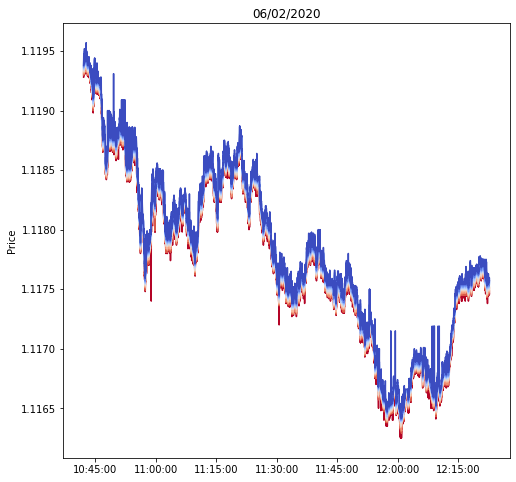

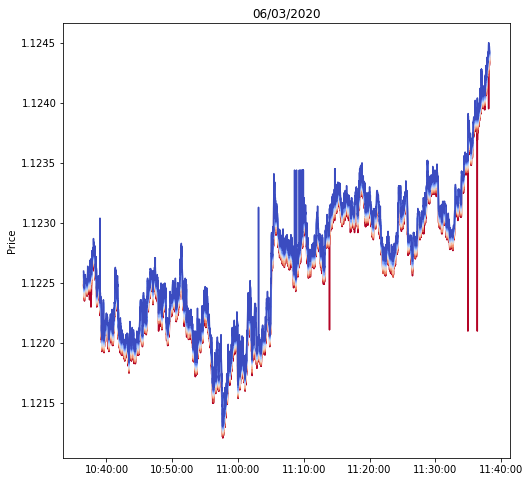

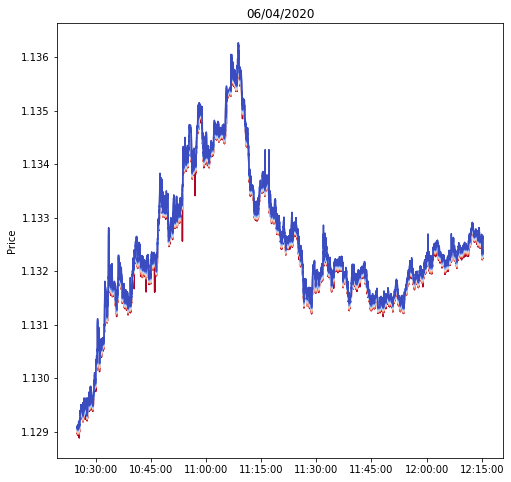

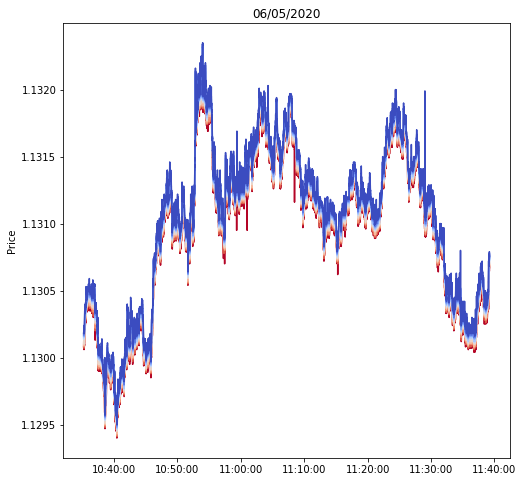

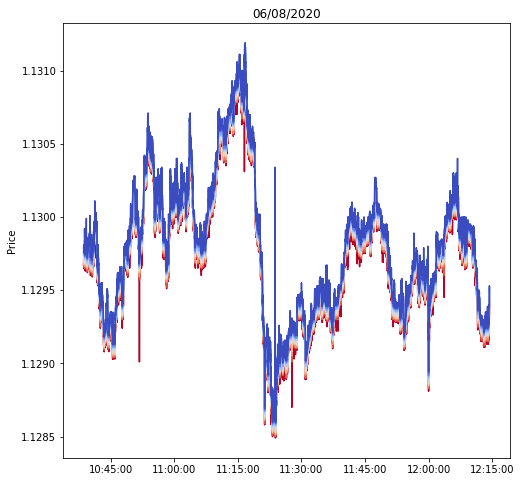

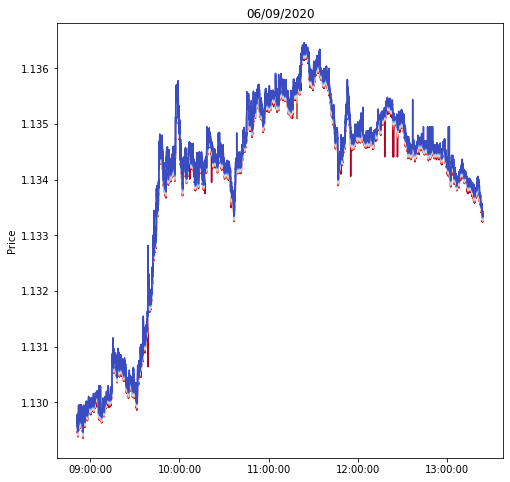

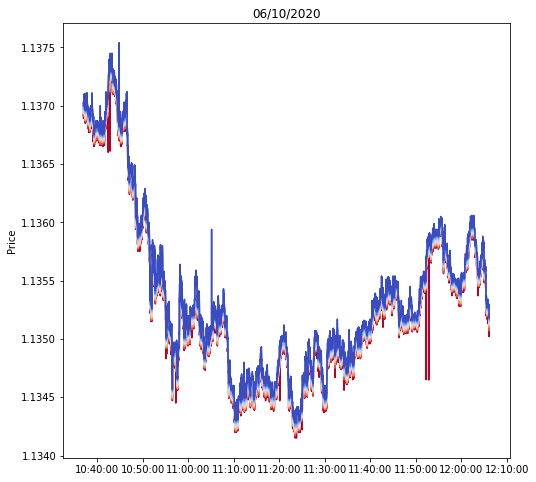

In [ ]:
for reduced_ob in all_reduced_and_combined_ob:
  Graph_OB_fn(reduced_ob)

# Data Standardization

In [ ]:
def Create_Dataset(reduced_ob, price_horizon=1500, forecast_horizon=300, save=True, graph=False):
  # X is a 3 dimensional numpy array with the first dimension in time
  # the second dimension from lowest Bid to highest offer (size_cols), and
  # the third dimension split between size data and price data (layers)
  # Y is a 2 dimensional numpy array with the first dimension in time, and
  # the second dimension being one value, either -1, 0, or 1, signifying
  # whether prices rose stayed constant or fell a minute into the future

  df = pd.read_pickle(reduced_ob)

  #create X
  #collect size and price cols
  size_cols = [column for column in df.keys() if 'Size' in column]
  price_cols = [column for column in df.keys() if 'Size' not in column]
  index_cols = price_cols.pop(0)

  #calculate mid
  df['Mid'] = (df['Ask1'] + df['Bid1']) / 2

  #change to size data to log
  df.loc[:, size_cols] = np.log(df[size_cols])

  #use day's high/low to scale
  size_scaler = MinMaxScaler()
  df[size_cols] = size_scaler.fit_transform(df[size_cols])
  
  #standardize price data to mid mean and trailing standard deviation (5 min default)
  df['STD_roll'] = df['Mid'].rolling(price_horizon).std()
  df.loc[:, price_cols] = df[price_cols].sub(df['Mid'], axis=0).div(df['STD_roll'], axis=0)
  df.drop(columns=['STD_roll'])

  #create numpy X with extra dimension
  size_df = df[size_cols].to_numpy()[...,None]
  price_df = df[price_cols].to_numpy()[..., None]

  #create X
  X = np.concatenate([size_df, price_df], -1)

  #create Y
  #create target variables

  #Calculate rolling average prices
  df['AveragePrice'] = df['Mid'].rolling(forecast_horizon).mean()

  #Shift Average Price column
  df['AveragePrice_S'] = df['AveragePrice'].shift(-forecast_horizon)

  #create average price labels
  def avg_price_labeler(df):
    alpha = .00005
    if df['AveragePrice'] - alpha > df['AveragePrice_S']:
        return -1   #average price trended down
    elif df['AveragePrice'] + alpha < df['AveragePrice_S']:
        return 1    #average price trended up
    else:
        return 0

  df['TrendLabel'] = df.apply(avg_price_labeler, axis = 1)
  df['TrendLabel'].value_counts()

  Y = df['TrendLabel'].to_numpy().reshape(-1,1)

  X = X[price_horizon:-forecast_horizon,:,:]
  Y = Y[price_horizon:-forecast_horizon,:]

  date_from_file = reduced_ob.split('/')[5]

  path = '/'.join(reduced_ob.split('/')[:4]) + '/SmallDataFiles'
  if not os.path.exists(path):
    os.makedirs(path)
  
  if save:
    np.save('/'.join([path, date_from_file]) + '_X.npy', X)
    np.save('/'.join([path, date_from_file]) + '_Y.npy', Y)

  if graph:
    
    graphsize = graph[:-1] + 'Size' + graph[-1]

    #used to graph standardizations
    test = pd.read_pickle(reduced_ob)
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    ax = fig.add_subplot(221)
    ax.set_title('Ask1 (Price) standardized')
    xpos = mdates.date2num(df.index.tolist())
    ypos = df.loc[:, graph].to_numpy()
    ax.plot(xpos, ypos)

    ax = fig.add_subplot(222)
    ax.set_title('AskSize1 (Size) standardized')
    xpos = mdates.date2num(df.index.tolist())
    ypos = df.loc[:, graphsize].to_numpy()
    ax.plot(xpos, ypos)

    ax = fig.add_subplot(223)
    ax.set_title('Original Price Time Series')
    xpos = mdates.date2num(test.index.tolist())
    ypos = test.loc[:,graph].to_numpy()
    ax.plot(xpos, ypos)

    ax = fig.add_subplot(224)
    ax.set_title('Original Size Time Series')
    xpos = mdates.date2num(test.index.tolist())
    ypos = test.loc[:,graphsize].to_numpy()
    ax.plot(xpos, ypos)

    plt.show()

  return X, Y



In [ ]:
for reduced_ob in all_reduced_and_combined_ob:
  _, _ = Create_Dataset(reduced_ob)

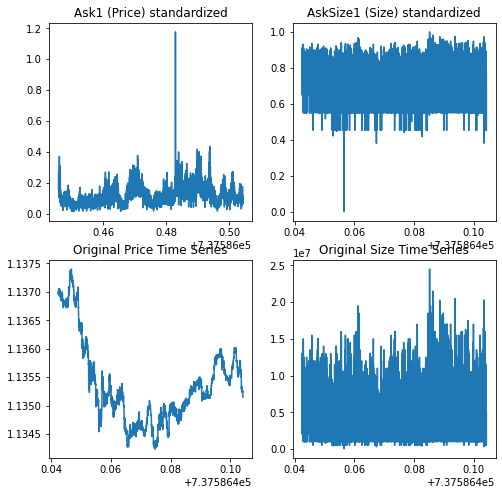

In [ ]:
#show graphs
_, _ = Create_Dataset(all_reduced_and_combined_ob[-1], save=False, graph='Ask2')


---



# Build Data Generator

In [ ]:
#Collect Datafiles
datapath = '/gdrive/My Drive/Stardust/SmallDataFiles'
data_files = []

for root, dirs, files in os.walk(datapath):
  for f in files:
    if '.npy' in f:
      data_files.append(os.path.join(datapath, f))

data_files = [filename for filename in data_files if 'small' not in filename]

# training / validation split
val_data_files = data_files[-2:]
data_files = data_files[:-2]

#confirm split
print('Training Files:')
for f in data_files:
  print(f)

print('Validation Files:')
for f in val_data_files:
  print(f)

Training Files:
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-02_X.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-02_Y.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-03_X.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-03_Y.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-04_X.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-04_Y.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-05_X.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-05_Y.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-08_X.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-08_Y.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-09_X.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-09_Y.npy
Validation Files:
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-10_X.npy
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-10_Y.npy


**Collect X and Y**
* Store all lengths of X as dictionary
* Number all X files
* Generator looks up the first 32 index tuples and then appends chosen X and Y's to batch
* Yield a batch




In [ ]:
# Error check
error_check = False

# Collect X files
x_files = [f for f in data_files if '_X' in f]

#collect Y's
y_files = [f for f in data_files if '_Y' in f]

# Ensure x and y files are sorted
x_files = sorted(x_files)
y_files = sorted(y_files)

# Collect X file lengths into dictionary
x_file_lengths = {f : len(np.load(f)) for f in x_files}

# Print X file lengths
print(f'X File Lengths by Filename:')
for key, item in x_file_lengths.items():
  print(f'{key} : {item}')

if not len(x_files) == len(y_files):
  print(f'Check uploaded files!')
  error_check = True

# Sum total lines in X files
total_X_length = sum(x_file_lengths[key] for key in x_file_lengths)

# Sum total y lengths
total_y_length = 0
for f in y_files:
  total_y_length += len(np.load(f))

# Ensure match with Y length
if not total_X_length == total_y_length:
  print(f'Check X and Y lengths!')
  error_check = True

# Total number of lines
print(f'Total number of lines in training set: {total_X_length}')

if error_check:
  print("***WARNING*** 1 or more errors!")

X File Lengths by Filename:
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-02_X.npy : 28379
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-03_X.npy : 16716
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-04_X.npy : 31017
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-05_X.npy : 17401
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-08_X.npy : 26935
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-09_X.npy : 79596
Total number of lines in training set: 200044


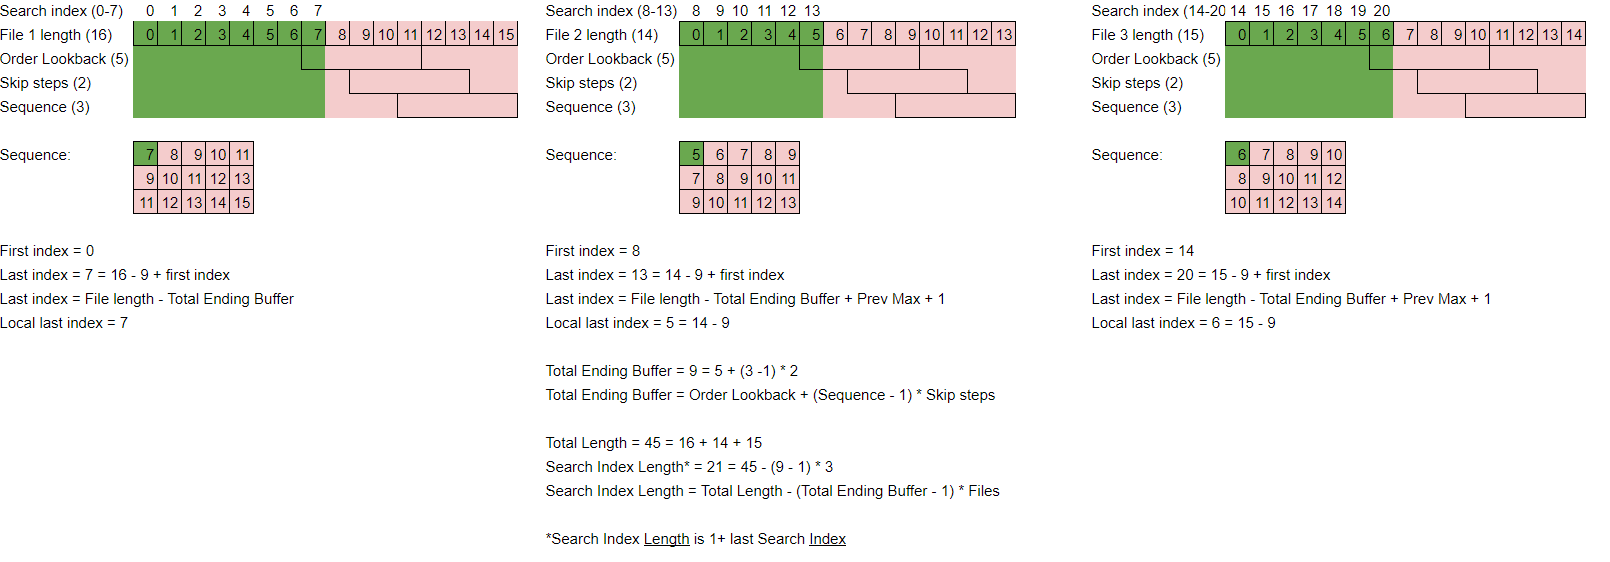

**Create index lookup for X**

Using example as illistrated above. 3 files of various length each. 5 lookback. 2 Skip steps. 3 Total sequences.
*  total_X_length = 45
*  tuple_to_file = {(0, 7): first.npy, (8, 13): second.npy, (14, 20): third.npy}

`index_list = [0, 1, 2, 3, ... , 18, 19, 20] = list(range(21))`


In [ ]:
#creates a tuple to key and index list for look up
orderbook_look_size = 5  #same as the first dimension of the input
sequence_length = 60   #same as the number of LSTM units
skips_per_sequence = 5  #5 equals 1 second

total_ending_buffer = orderbook_look_size + (sequence_length - 1) * skips_per_sequence

index_list = list(range(
                  total_X_length - 
                  (total_ending_buffer - 1) * len(x_file_lengths)
                        ))

tuple_to_key = {}
low_index = 0
max_index = 0
for date_key in sorted(x_file_lengths):
  max_index += x_file_lengths[date_key] - total_ending_buffer 
  tuple_to_key[(low_index, max_index)] = date_key
  low_index = max_index + 1
  max_index += 1


for t, f in tuple_to_key.items():
  print(f'{t} : {f}')

print(f'Final search index value: {index_list[-1]}\n\
Final search index length: {len(index_list)} (should be +1 more to zero counting)')

(0, 28079) : /gdrive/My Drive/Stardust/SmallDataFiles/2020-06-02_X.npy
(28080, 44496) : /gdrive/My Drive/Stardust/SmallDataFiles/2020-06-03_X.npy
(44497, 75214) : /gdrive/My Drive/Stardust/SmallDataFiles/2020-06-04_X.npy
(75215, 92316) : /gdrive/My Drive/Stardust/SmallDataFiles/2020-06-05_X.npy
(92317, 118952) : /gdrive/My Drive/Stardust/SmallDataFiles/2020-06-08_X.npy
(118953, 198249) : /gdrive/My Drive/Stardust/SmallDataFiles/2020-06-09_X.npy
Final search index value: 198249
Final search index length: 198250 (should be +1 more to zero counting)


** Repeat indexing for validation set**

In [ ]:
# repeat process for validation set
# check for errors
error_check = False

# Collect X files
val_x_files = [f for f in val_data_files if '_X' in f]

#collect Y's
val_y_files = [f for f in val_data_files if '_Y' in f]

# Ensure x and y files are sorted
val_x_files = sorted(val_x_files)
val_y_files = sorted(val_y_files)

# Collect X file lengths into dictionary
val_x_file_lengths = {f : len(np.load(f)) for f in val_x_files}

# Print X file lengths
print(f'Val X File Lengths by Filename:')
for key, item in val_x_file_lengths.items():
  print(f'{key} : {item}')

if not len(val_x_files) == len(val_y_files):
  print(f'Check uploaded files!')
  error_check = True

# Sum total lines in X files
val_total_X_length = sum(val_x_file_lengths[key] for key in val_x_file_lengths)

# Sum total y lengths
val_total_y_length = 0
for f in val_y_files:
  val_total_y_length += len(np.load(f))

# Ensure match with Y length
if not val_total_X_length == val_total_y_length:
  print(f'Check Validation X and Y lengths!')

# Total number of lines
print(f'Total number of lines in validation set: {val_total_X_length}')

if error_check:
  print("***WARNING*** 1 or more errors!")

#creates a validation tuple to key and index list for look up
val_index_list = list(range(
                  val_total_X_length - 
                  (total_ending_buffer - 1) * len(val_x_file_lengths)
                        ))

val_tuple_to_key = {}
val_low_index = 0
val_max_index = 0
for date_key in sorted(val_x_file_lengths):
  val_max_index += val_x_file_lengths[date_key] - total_ending_buffer 
  val_tuple_to_key[(val_low_index, val_max_index)] = date_key
  val_low_index = val_max_index + 1
  val_max_index += 1


for t, f in val_tuple_to_key.items():
  print(f'{t} : {f}')

print(f'Final search index value: {val_index_list[-1]}\n\
Final search index length: {len(val_index_list)} (should be +1 more to zero counting)')



Val X File Lengths by Filename:
/gdrive/My Drive/Stardust/SmallDataFiles/2020-06-10_X.npy : 24955
Total number of lines in validation set: 24955
(0, 24655) : /gdrive/My Drive/Stardust/SmallDataFiles/2020-06-10_X.npy
Final search index value: 24655
Final search index length: 24656 (should be +1 more to zero counting)


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, tuple_to_key, index_list, batch_size=32, dim=(5,10), n_channels=2,
                 n_classes=3, split=.00005, shuffle=True, verbose=False,
                 orderbook_look_size=5, sequence_length = 60, skips_per_sequence = 5):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.tuple_to_key = tuple_to_key
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.index_list = index_list
        self.orderbook_look_size = dim[0]
        self.sequence_length = sequence_length 
        self.skips_per_sequence = skips_per_sequence
        self.verbose=verbose
        self.split = split
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.index_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self, verbose=True):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.index_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        if verbose:
          print(f'New Shuffle! Index beginning {self.indexes[:3]}')

    def Y_one_hot(self, single_Y):
      category_Y = np.zeros((self.n_classes))
      if single_Y == 1:
        category_Y[2] = 1
      elif single_Y == -1:
        category_Y[0] = 1
      else:
        category_Y[1] = 1
      return category_Y

    def __data_generation(self, indexes, verbose = False):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        # **
        X_dim_expand = self.dim[0] * self.dim[1] * self.n_channels
        X = np.empty((self.batch_size, self.sequence_length, X_dim_expand))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for batch_i, ID in enumerate(indexes):
            # Find index within tuple dictionary
            for tuple_pair in self.tuple_to_key:
              if ID >= tuple_pair[0] and ID < tuple_pair[1]:
                f = self.tuple_to_key[tuple_pair]
                y_file = f.split('_')[0]+'_Y.npy'

                # Print index range with file name
                if verbose:
                  print(f'{ID}\'s first spatial temporal panel uses X: {f} lines {ID-tuple_pair[0]} to {ID-tuple_pair[0]+self.orderbook_look_size} \n\
                  Y: {y_file} line {ID-tuple_pair[0]+self.orderbook_look_size}')
                
                # Load numpy file
                numpy_f = np.load(f)

                #**
                # Batch Sequences
                batch_X_sequence = np.empty([self.sequence_length, X_dim_expand])
                batch_y_sequence = np.empty([self.n_classes])

                # Collect X and y sequences
                for sequence_i in range(self.sequence_length):
                  batch_X_sequence[sequence_i, ...] = numpy_f[ID-tuple_pair[0]+sequence_i*self.skips_per_sequence : \
                                                              ID-tuple_pair[0]+self.orderbook_look_size+sequence_i*self.skips_per_sequence,...].reshape(1, -1)
                
                #**
                # Collect y
                pre_cat_y = np.load(y_file)[ID-tuple_pair[0]+self.orderbook_look_size+(self.sequence_length-1)*self.skips_per_sequence, ... ]
                batch_y_sequence[...] = self.Y_one_hot(pre_cat_y)
                  
                # Store X sample
                X[batch_i, ...] = batch_X_sequence
                y[batch_i, ...] = batch_y_sequence

        return X, y

In [ ]:
sample_generator = DataGenerator(tuple_to_key, index_list, shuffle=False, dim=(5,10), batch_size=2, sequence_length=60)

X, y = sample_generator.__getitem__(0)

print(X.shape)
print(y.shape)

New Shuffle! Index beginning [0 1 2]
(2, 60, 100)
(2, 3)


In [ ]:
print(X[0,0,:])
print(X[0,1,:])

[ 0.84021169 -0.40511653  0.72148065 -0.28046529  0.685607   -0.21813967
  0.68056024 -0.15581405  0.51534061 -0.03116281  0.61661597  0.03116281
  0.8620247   0.09348843  0.81690817  0.15581405  0.82411925  0.21813967
  0.75179914  0.28046529  0.74300835 -0.2799902   0.776049   -0.21777016
  0.4989734  -0.15555011  0.48413352 -0.09333007  0.4669438  -0.03111002
  0.71415203  0.03111002  0.9240538   0.09333007  0.69191118  0.15555011
  0.69882172  0.21777016  0.55509237  0.2799902   0.74300835 -0.27951385
  0.7826714  -0.21739966  0.4361203  -0.15528547  0.42283495 -0.09317128
  0.54967869 -0.03105709  0.69536219  0.03105709  0.91658975  0.09317128
  0.74164515  0.15528547  0.69882172  0.21739966  0.55509237  0.27951385
  0.64580501 -0.27903642  0.78500387 -0.21702832  0.53290114 -0.15502023
  0.56136058 -0.09301214  0.4669438  -0.03100405  0.71415203  0.03100405
  0.90047143  0.09301214  0.75484498  0.15502023  0.64227244  0.21702832
  0.55509237  0.27903642  0.64580501 -0.2785627   0

In [ ]:
print(y[0])

[0 0 1]


# Model Structure

Model uses 2 layers of CNNs to extract important features out of the Limit Order Book. Kernel size is 1 second by 2 positions, with valid padding, then a max pooling layer by second with a stride of 1 second. Then another convolutional layer with more filters and no strides. Finally a reduction in time axis by half by max pool.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras

# define LSTM model
model = Sequential()
model.add(keras.layers.InputLayer((None, 100)))

# finish with 30 time step LSTM (2 second sequences each, 1 minute)
model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(LSTM(60, activation='relu'))
model.add(Dense(3))

#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#summary of model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, None, 60)          38640     
_________________________________________________________________
lstm_6 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 183       
Total params: 67,863
Trainable params: 67,863
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
# Parameters
params = {'dim': (5, 10),
          'batch_size': 128,
          'n_classes': 3,
          'n_channels': 2,
          'shuffle': True}

training_generator = DataGenerator(tuple_to_key, index_list, **params)

validation_generator = DataGenerator(val_tuple_to_key, val_index_list, **params)





New Shuffle! Index beginning [ 36176 112745 148559]
New Shuffle! Index beginning [21844  3307 11663]


In [ ]:
checkpoint_filepath = '/gdrive/My Drive/Stardust/Models/20201026/'


model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=True,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True)

In [ ]:
history = model.fit(training_generator,
                    epochs = 5,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[model_checkpoint_callback])


Epoch 1/5
1548/1548 [==============================] - 2198s 1s/step - loss: 6.0399 - accuracy: 0.3745 - val_loss: 5.9511 - val_accuracy: 0.3692
New Shuffle! Index beginning [63980 20771 81977]
Epoch 2/5
1548/1548 [==============================] - 2195s 1s/step - loss: 6.0357 - accuracy: 0.3745 - val_loss: 5.9184 - val_accuracy: 0.3672
New Shuffle! Index beginning [164443 113291  56022]
Epoch 3/5
1548/1548 [==============================] - 2150s 1s/step - loss: 45915348992.0000 - accuracy: 0.3744 - val_loss: 5.8000 - val_accuracy: 0.3598
New Shuffle! Index beginning [142792  74802 145951]
Epoch 4/5
1548/1548 [==============================] - 2126s 1s/step - loss: 3756487168.0000 - accuracy: 0.3744 - val_loss: 5.8076 - val_accuracy: 0.3603
New Shuffle! Index beginning [127642 181441 136920]
Epoch 5/5
1548/1548 [==============================] - 2085s 1s/step - loss: 349378.9688 - accuracy: 0.3744 - val_loss: 5.8907 - val_accuracy: 0.3655
New Shuffle! Index beginning [ 98028  86970 12

In [ ]:
save_path = '/gdrive/My Drive/Stardust/Models/20201022/'
if not os.path.exists(save_path):
  os.makedirs(save_path)

model.save(os.path.join(save_path, 'Model01'))

INFO:tensorflow:Assets written to: /gdrive/My Drive/Stardust/Models/20200916/Model02/assets
